In [62]:
import numpy as np
import os
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

plt.style.use('dark_background')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
train_val_dir = pathlib.Path('data/train')
test_dir = pathlib.Path('data/test')

In [16]:
batch_size = 32
img_height = 256
img_width = 256 

Found 12906 files belonging to 3 classes.
Using 10325 files for training.
Using 2581 files for validation.
Found 3224 files belonging to 3 classes.
[{'cat': 5653}, {'dog': 5239}, {'wild': 5238}]


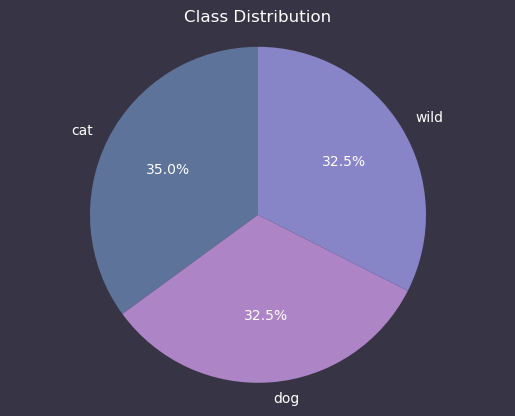

In [21]:
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    seed=99,
    subset='both',
    batch_size=batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

counts = []
for label in train_dataset.class_names:
    counts.append({label: len(list(train_val_dir.glob(label+'/*'))) + len(list(test_dir.glob(label+'/*')))})

print(counts)

slice_colors = ['#5d739a', '#ad84c6', '#8784c7']
# piechart of class distribution
sizes = [list(count.values())[0] for count in counts]
fig1, ax1 = plt.subplots()
fig1.patch.set_facecolor('#373545')
ax1.pie(sizes, labels=train_dataset.class_names, autopct='%1.1f%%', colors=slice_colors, startangle=90)
ax1.axis('equal')
plt.title('Class Distribution')
plt.show()

In [6]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print('class names:', class_names, '\nnum classes:', num_classes)

class names: ['cat', 'dog', 'wild'] 
num classes: 3


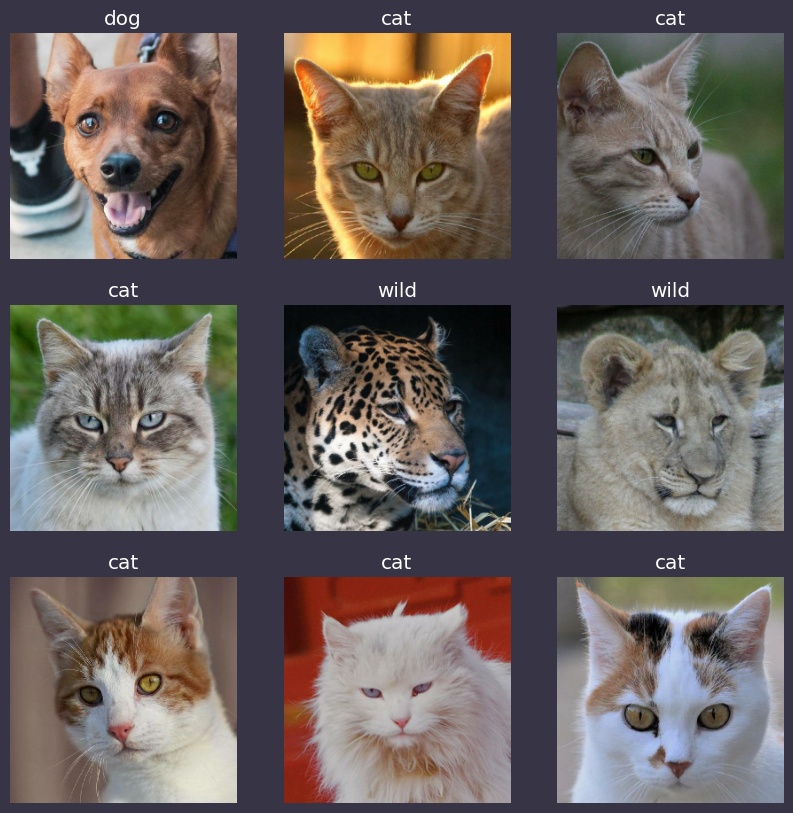

In [78]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('#373545')
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Preprocessing layers

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256, 256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(0.2),
])

In [116]:
model = tf.keras.Sequential([
    # Preprocessing layers
    resize_and_rescale,
    data_augmentation,
    
    # Convolutional layer #1
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Convolutional layer #2
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Convolutional layer #3
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Convolutional layer #4
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Convolutional layer #5
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Fully connected layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),

    # Dropout against dying relu
    tf.keras.layers.Dropout(.5),

    # Output layer
    tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.build((None, img_height, img_width, 3))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 64, 64, 128)     

In [111]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model, font=font, background_fill="#373545").show()

In [117]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=4, batch_size=batch_size)

Epoch 1/4


323/323 [==============================] - 27s 80ms/step - loss: 0.7889 - accuracy: 0.5968 - val_loss: 0.2856 - val_accuracy: 0.8826
Epoch 2/4
323/323 [==============================] - 26s 80ms/step - loss: 0.2258 - accuracy: 0.9177 - val_loss: 0.1784 - val_accuracy: 0.9330
Epoch 3/4
323/323 [==============================] - 24s 74ms/step - loss: 0.1220 - accuracy: 0.9569 - val_loss: 0.0972 - val_accuracy: 0.9698
Epoch 4/4
323/323 [==============================] - 22s 68ms/step - loss: 0.0867 - accuracy: 0.9695 - val_loss: 0.0753 - val_accuracy: 0.9737


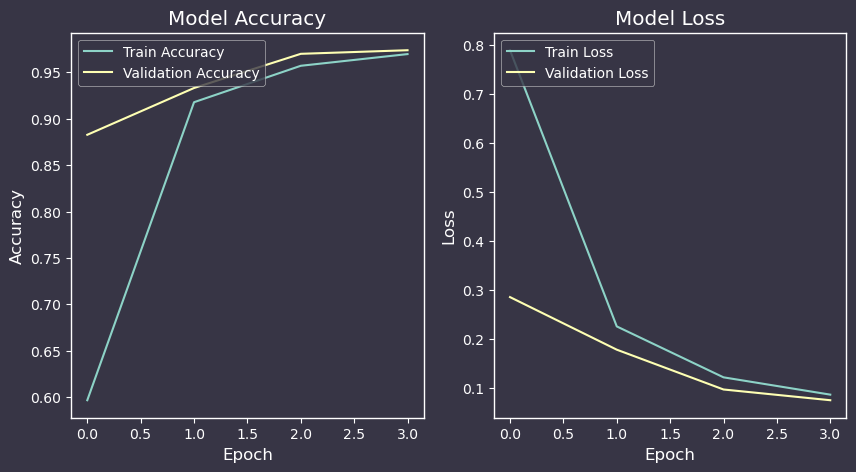

In [118]:
history = model.history

# plot model history with plt
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('#373545')
ax = fig.add_subplot(1, 2, 1)
ax.grid(False)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')

ax = fig.add_subplot(1, 2, 2)
ax.grid(False)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

array([1, 2, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 1, 1, 2,
       2, 2, 1, 2, 1, 2, 1, 0, 2, 0])

              precision    recall  f1-score   support

         cat       0.98      0.97      0.97      1130
         dog       0.95      0.95      0.95      1047
        wild       0.95      0.97      0.96      1047

    accuracy                           0.96      3224
   macro avg       0.96      0.96      0.96      3224
weighted avg       0.96      0.96      0.96      3224



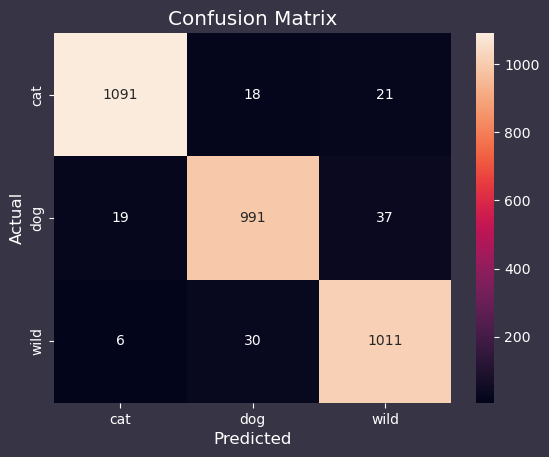

In [119]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

colors = ['#5d739a', '#ad84c6', '#8784c7']

y_test = []
y_pred = []

for batch in test_dataset.as_numpy_iterator():
    images, labels = batch
    pred = model.predict(images, verbose=0)
    y_pred.append(np.argmax(pred, axis=1))
    y_test.append(labels)

y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

cm = confusion_matrix(y_test, y_pred)

sns.set_style({'axes.facecolor': '#373545', 'figure.facecolor': '#373545'})

m = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

class_report = classification_report(y_test, y_pred, target_names=class_names)
print(class_report)

m.set_title('Confusion Matrix')
m.set_xlabel('Predicted')
m.set_ylabel('Actual')
plt.show()

In [120]:
loc = os.path.join(os.getcwd(), 'models', 'model.h5')
localhost_save_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
model.save(loc, options=localhost_save_option)